In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import yfinance as yf
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, explained_variance_score
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import PowerTransformer

import warnings
warnings.filterwarnings("ignore")

In [2]:
vix_data = yf.download('^VIX', start='2008-01-01')
vix_data['VIX_close'] = vix_data['Adj Close']

vol_df = pd.read_csv('volatility_df.csv', 
                     parse_dates=['Date'], index_col='Date')

volatility_df = pd.merge_asof(vol_df, vix_data['VIX_close'], left_index=True, right_index=True, direction='nearest')
volatility_df = volatility_df.set_index(vol_df.index)
volatility_df.isna().sum()

[*********************100%%**********************]  1 of 1 completed


Recovered_vol                    0
Risk_premium                     0
Risk_preference                  0
Risk_neutral_skewness            0
Risk_neutral_kurtosis            0
Recovered_skewness               0
Recovered_kurtosis               0
USA_10_y_treasuries              0
Effective_Fed_Funds_Rate_true    0
Consumer_Price_Index_true        0
Producer_Price_Index_true        0
Unemployment_Rate_true           0
GDP_true                         0
Industrial_Production_true       0
Mortgage_Rates_true              0
Realized_Volatility              0
VIX_close                        0
dtype: int64

In [3]:
volatility_df = volatility_df[['Recovered_vol', 'Realized_Volatility']]

volatility_df = volatility_df.replace([0], 1e-6)

volatility_df = volatility_df / volatility_df.shift(1) - 1

lag = -5
volatility_df[f'Realized_Volatility_(t+{abs(lag)})'] = volatility_df['Realized_Volatility'].shift(lag)
volatility_df = volatility_df.dropna()
volatility_df.drop('Realized_Volatility', axis=1, inplace=True)
print(len(volatility_df))
volatility_df.head(10)

3357


,Recovered_vol,Realized_Volatility_(t+5)
Date,,
2010-01-05,-0.024188,0.031692
2010-01-06,0.001425,0.029962
2010-01-07,0.007015,-0.022161
2010-01-08,0.030061,0.046408
2010-01-11,0.030583,0.073188
2010-01-12,-0.037054,-0.011969
2010-01-13,0.161288,0.137014
2010-01-14,0.012751,0.125819
2010-01-15,-0.231002,0.002256


In [4]:
# Стандартизация, нормализация, замена выбросов медианой

values_clear = volatility_df.copy()

train_size = int(len(values_clear) * 0.7)
val_size = int(len(values_clear) * 0.15)
test_size = len(values_clear) - train_size - val_size

train = values_clear.iloc[:train_size]
val = values_clear.iloc[train_size:train_size + val_size]
test = values_clear.iloc[train_size + val_size:]

# Обучаем стандартизатор, нормализатор и изолейшн форест на тренировочных данных
transformer = PowerTransformer(method='yeo-johnson')
transformer.fit(train)
train_transformed = transformer.transform(train)

scaler = MinMaxScaler(feature_range=(1e-6, 1))
scaler.fit(train_transformed)
train_scaled = scaler.transform(train_transformed)

isolation_forest = IsolationForest(n_estimators=1000, contamination=0.01, random_state=42) # 0.01
isolation_forest.fit(train_scaled)

normalizer = Normalizer()
normalizer.fit(train_scaled)

# Применяем стандартизатор, нормализатор и изолейшн форест на тренировочных, валидационных и тестовых данных
train_isolation_forest = isolation_forest.predict(train_scaled)
train_normalized = normalizer.transform(train_scaled)

val_transformed = transformer.transform(val)
val_scaled = scaler.transform(val_transformed)
val_isolation_forest = isolation_forest.predict(val_scaled)
val_normalized = normalizer.transform(val_scaled)

test_transformed = transformer.transform(test)
test_scaled = scaler.transform(test_transformed)
test_isolation_forest = isolation_forest.predict(test_scaled)
test_normalized = normalizer.transform(test_scaled)

# Считаем метрику
train_values = np.median(train_scaled, axis=0)
val_values = np.median(val_scaled, axis=0)
test_values = np.median(test_scaled, axis=0)

# Заполняем выбросы медианой
train_scaled[train_isolation_forest == -1] = train_values
val_scaled[val_isolation_forest == -1] = val_values
test_scaled[test_isolation_forest == -1] = test_values

y_train = train_scaled[:, -1:]
y_train = np.squeeze(y_train)
X_train = np.delete(train_scaled, -1, axis=1)

y_val = val_scaled[:, -1:]
y_val = np.squeeze(y_val)
X_val = np.delete(val_scaled, -1, axis=1)

y_test = test_scaled[:, -1:]
y_test = np.squeeze(y_test)
X_test = np.delete(test_scaled, -1, axis=1)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(2349, 1) (2349,) (503, 1) (503,) (505, 1) (505,)


In [6]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.svm import SVR

# создаем пайплайн
pipe = Pipeline([
    ('regressor', SVR(verbose=False)),
])

# определяем гиперпараметры для поиска
param_grid = {
    'regressor__kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
    'regressor__C': [0.1, 0.01, 0.5, 1, 5, 10, 50, 100],
    'regressor__gamma': [5, 1, 0.1, 0.01, 0.001],
    'regressor__degree': [2, 3, 4, 5],
    'regressor__epsilon': [0.1, 0.25, 0.5, 0.75, 1, 2, 5]
}

tscv = TimeSeriesSplit(n_splits=5)

# создаем Grid Search CV
grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=tscv,
    refit=True,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print('Лучшие гиперпараметры:', grid_search.best_params_)

print('MSE на валидационном наборе данных:', -grid_search.best_score_)

Fitting 5 folds for each of 4480 candidates, totalling 22400 fits
Лучшие гиперпараметры: {'regressor__C': 0.01, 'regressor__degree': 2, 'regressor__epsilon': 0.1, 'regressor__gamma': 5, 'regressor__kernel': 'sigmoid'}
MSE на валидационном наборе данных: 0.0016112379190584996


In [7]:
# Лучшие гиперпараметры: {'regressor__C': 0.01, 'regressor__degree': 2, 'regressor__epsilon': 0.1, 'regressor__gamma': 5, 'regressor__kernel': 'sigmoid'}
# MSE на валидационном наборе данных: 0.0016112379190584996

In [8]:
# Предсказание значений на валидационной выборке
val_pred = grid_search.predict(X_val)

print(f'MSE val: {mean_squared_error(y_val, val_pred):.4f}')
print(f'MAE val: {mean_absolute_error(y_val, val_pred):.4f}')
print(f'R2 val: {r2_score(y_val, val_pred):.4f}')
print(f'MAPE val: {mean_absolute_percentage_error(y_val, val_pred):.4f}')

# Предсказание значений на тестовой выборке
y_pred = grid_search.predict(X_test)

print()
print(f'MSE test: {mean_squared_error(y_test, y_pred):.4f}')
print(f'MAE test: {mean_absolute_error(y_test, y_pred):.4f}')
print(f'R2 test: {r2_score(y_test, y_pred):.4f}')
print(f'MAPE test: {mean_absolute_percentage_error(y_test, y_pred):.4f}')

MSE val: 0.0014
MAE val: 0.0230
R2 val: -0.0168
MAPE val: 0.0372

MSE test: 0.0009
MAE test: 0.0195
R2 test: -0.0282
MAPE test: 0.0319


In [9]:
# Вычисление квантильных ошибок
quan = []
for q in np.arange(0, 1.1, 0.1):
    quantile_error = np.abs(np.quantile(y_test, q) - np.quantile(y_pred, q))
    quan.append(quantile_error)
    print(f'Ошибка для квантиля {q.round(2)}: {quantile_error.round(3)}')

Ошибка для квантиля 0.0: 0.177
Ошибка для квантиля 0.1: 0.024
Ошибка для квантиля 0.2: 0.01
Ошибка для квантиля 0.3: 0.0
Ошибка для квантиля 0.4: 0.004
Ошибка для квантиля 0.5: 0.005
Ошибка для квантиля 0.6: 0.006
Ошибка для квантиля 0.7: 0.01
Ошибка для квантиля 0.8: 0.019
Ошибка для квантиля 0.9: 0.037
Ошибка для квантиля 1.0: 0.134


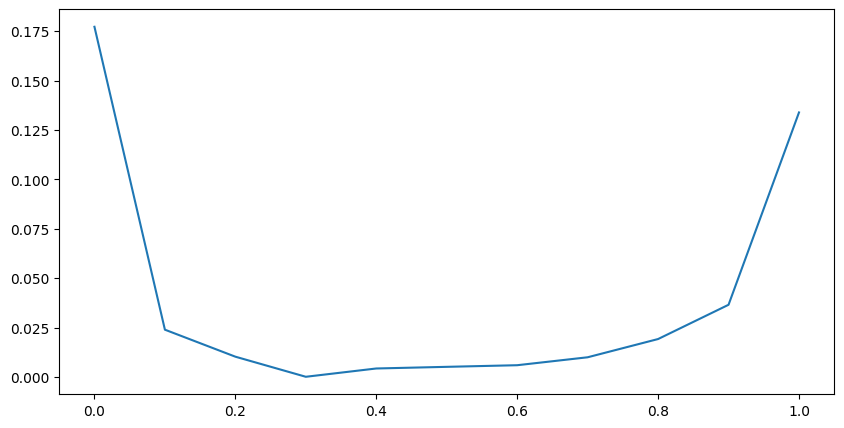

In [10]:
# График квантильной ошибки
quan_df = pd.DataFrame(quan, columns=['quantile error'])

index = np.arange(0, len(quan_df)*0.1, 0.1)
quan_df.set_index(index, inplace=True)

plt.figure(figsize=(10, 5))
plt.plot(quan_df)
plt.show()